# SVM on Pima Indians Diabetes Data Set

数据说明：
Pima Indians Diabetes Data Set（皮马印第安人糖尿病数据集） 根据现有的医疗信息预测5年内皮马印第安人糖尿病发作的概率。   

数据集共9个字段: 
0列为怀孕次数；
1列为口服葡萄糖耐量试验中2小时后的血浆葡萄糖浓度；
2列为舒张压（单位:mm Hg）
3列为三头肌皮褶厚度（单位：mm）
4列为餐后血清胰岛素（单位:mm）
5列为体重指数（体重（公斤）/ 身高（米）^2）
6列为糖尿病家系作用
7列为年龄
8列为分类变量（0或1）

数据链接：https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

#竞赛的评价指标为logloss
from sklearn.metrics import log_loss  

#SVM并不能直接输出各类的概率，所以在这个例子中我们用正确率作为模型预测性能的度量
from sklearn.metrics import accuracy_score

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据 

In [8]:
#input data
train = pd.read_csv("FE_pima-indians-diabetes.csv")
train.head()

,instant,pregnants,Plasma_glucose_concentration,blood_pressure,Triceps_skin_fold_thickness,serum_insulin,BMI,Diabetes_pedigree_function,Age,Target
0,0,0.639947,0.866045,-0.031990,0.670643,-0.181541,0.166619,0.468492,1.425995,1
1,1,-0.844885,-1.205066,-0.528319,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672,0
2,2,1.233880,2.016662,-0.693761,-0.012301,-0.181541,-1.332500,0.604397,-0.105584,1
3,3,-0.844885,-1.073567,-0.528319,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549,0
4,4,-1.141852,0.504422,-2.679076,0.670643,0.316566,1.549303,5.484909,-0.020496,1


## 数据预处理

In [23]:

# 用train_test_split 分割训练数据和测试数据
from sklearn.model_selection import train_test_split
#  get labels
y = train['Target']   
X = train.drop(["Target"], axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=0)

#保存测试ID，用于提交结果
testID=X_test["instant"]

X_train.drop(["instant"],axis=1,inplace=True)
X_test.drop(["instant"],axis=1,inplace=True)
#用于特征重要性可视化
feat_names = X_train.columns
print(feat_names)


Index(['pregnants', 'Plasma_glucose_concentration', 'blood_pressure',
       'Triceps_skin_fold_thickness', 'serum_insulin', 'BMI',
       'Diabetes_pedigree_function', 'Age'],
      dtype='object')


## 模型训练
由于速度较慢，这里只调整了超参数C，没调L1/L2正则函数

In [21]:
#线性SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {'C': Cs}
grid = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5, n_jobs = 4)

grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.758957654723127
{'C': 10}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


大家可以对比一下用原始数据（标准化，但不做缺失值填补，即缺失值取0），效果更好。
SVM对噪声比较敏感（或许原始数据清洗的时候已经是上帝最好的安排了:) ）

In [13]:

df = pd.DataFrame({"columns":list(feat_names), "coeffient":list(grid.best_estimator_.coef_.T)})
df.sort_values(by=['coeffient'],ascending=False)

,columns,coeffient
1,Plasma_glucose_concentration,[0.9423617036822627]
5,BMI,[0.5551934906777518]
0,pregnants,[0.25477251251054867]
6,Diabetes_pedigree_function,[0.17149184133709605]
7,Age,[0.15095807903889025]
4,serum_insulin,[-0.07110400311162768]
3,Triceps_skin_fold_thickness,[-0.11772427161897739]
2,blood_pressure,[-0.17029771147666306]


### RBF核SVM正则参数调优

RBF核是SVM最常用的核函数。
RBF核SVM 的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和核函数的宽度gamma
C越小，决策边界越平滑； 
gamma越小，决策边界越平滑。

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gammas = [0.0001,0.001, 0.01, 0.1, 1]
#gammas =[1e-5, 1e-6]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, n_jobs = 4)

grid_rbf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

0.758957654723127
{'C': 10}


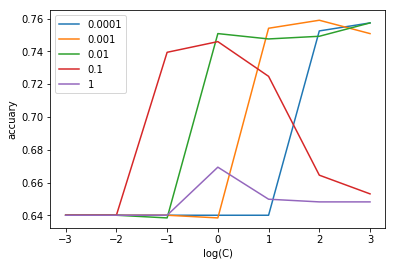

In [29]:
print(grid.best_score_)
print(grid.best_params_)

# plot CV误差曲线
test_means = grid_rbf.cv_results_[ 'mean_test_score' ]
test_stds = grid_rbf.cv_results_[ 'std_test_score' ]

# plot results
n_Cs = len(Cs)
number_gamms = len(gammas)

test_scores =  np.array(test_means).reshape(n_Cs,number_gamms)
#train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs,number_gamms)
#train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(gammas):
    pyplot.plot(x_axis, test_scores[:,i], label= gammas[i])
    #pyplot.errorbar(x_axis, test_scores[:,i], yerr=test_stds[:,i] ,label = gammas[i] )
    #pyplot.errorbar(x_axis, train_scores[:,i], yerr=train_stds[:,i] ,label = penaltys[i] +' Train')
    
pyplot.legend()
pyplot.xlabel( 'log(C)' )                                                                                                      
pyplot.ylabel( 'accuary' )
pyplot.savefig('SVMGridSearchCV_C.png' )

pyplot.show()

In [33]:
# C越大，最佳的gamma越小

#存储测试结果
y_test_pred=grid_rbf.predict(X_test)
df=pd.DataFrame({"instant":testID,"target":y_test_pred})
df.to_csv("submission.csv",index=False)
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 661 to 380
Data columns (total 2 columns):
instant    154 non-null int64
target     154 non-null int64
dtypes: int64(2)
memory usage: 3.6 KB
